# GA Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- [LDA Mallet Model](#LDA-Mallet-Model)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pprint import pprint
import os
from collections import Counter

# Bokeh package for TSNE
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Load the dataset

In [4]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


In [5]:
amd_df = GPU_df[GPU_df['tag'] == 'amd']
amd_df

,Reddit comments,tag
4698,sound samsung 8nm cheap,amd
4699,ethic mongol invasion tech,amd
4700,nvidia software ai learning big selling point,amd
4701,excited amd guy compete going nvidia brand loy...,amd
4702,think nvidia actualy competing new console pri...,amd
...,...,...
19219,dude understand example confused said looked r...,amd
19220,know example thought looked,amd
19221,probably score higher english proficiency test...,amd
19222,prove know concept cost opportunity efficiency...,amd


# Prepare comments for modeling

In [6]:
# Creates the bag of words for each document
data = [token.split() for token in amd_df['Reddit comments'].tolist()]

In [7]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['sound', 'samsung', '8nm', 'cheap'], ['ethic', 'mongol', 'invasion', 'tech'], ['nvidia', 'software', 'ai', 'learning', 'big', 'selling', 'point']]


# Phrase modeling: Bigram and Trigram models

In [8]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

In [10]:
# Create a dictionary to hold the different n-grams dataset
phrase_list = {'unigram': data, 'bigrams': data_bigrams, 'trigrams': data_trigrams}
# phrase_list

# LDA on AMD comments with all the ngrams

In [11]:
# Creating a function to create the LDA model and compute the coherence score
def lda_calculate_coherence_values(ngram_data, num_topics):
    """
    This function calculates the coherence score and the perplexity scores for each ngram and stores
    the model, corpus and the id2word in their respective dictionaries
    """
    model_dict = {}
    score_dict = {}
    for key, value in ngram_data.items():
        ngram_id2word = corpora.Dictionary(value)
        ngram_corpus = [ngram_id2word.doc2bow(text) for text in value]

        ngram_lda_model = LdaMulticore(corpus=ngram_corpus, 
                             id2word=ngram_id2word, 
                             num_topics=num_topics,
                             chunksize=100,
                             passes=20, 
                             random_state=42,
                            per_word_topics=True)


        # Compute Perplexity score
        ngram_perplexity = ngram_lda_model.log_perplexity(ngram_corpus)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ngram_lda_model, texts=value, dictionary=ngram_id2word, coherence='c_v')
        ngram_coherence_lda = coherence_model_lda.get_coherence()
        
        # Prints out the topics for each ngram
        print(f'*********Displaying {num_topics} topics for {key}******************')
        pprint(ngram_lda_model.print_topics())
        
        # Store the perplexity and coherence scores in score_dict
        score_dict[key] = []
        score_dict[key].append(ngram_perplexity)
        score_dict[key].append(ngram_coherence_lda)
        
        # Stores the ngram's model, corpus, id2word in model_dict
        model_dict[key] = []
        model_dict[key].append(ngram_lda_model)
        model_dict[key].append(ngram_corpus)
        model_dict[key].append(ngram_id2word)

    return score_dict, model_dict, num_topics

In [12]:
# Calculate using a dictionary
score_dict, model_dict, num_topics = lda_calculate_coherence_values(phrase_list, 5)

*********Displaying 5 topics for unigram******************
[(0,
  '0.024*"3080" + 0.022*"6800" + 0.020*"6800xt" + 0.019*"3070" + 0.017*"3090" '
  '+ 0.016*"vram" + 0.013*"6900xt" + 0.009*"xt" + 0.008*"price" + '
  '0.008*"better"'),
 (1,
  '0.028*"game" + 0.028*"dl" + 0.017*"amd" + 0.016*"ray" + 0.015*"tracing" + '
  '0.011*"nvidia" + 0.009*"rt" + 0.009*"support" + 0.008*"feature" + '
  '0.008*"driver"'),
 (2,
  '0.028*"price" + 0.019*"amd" + 0.011*"3070" + 0.011*"card" + 0.010*"year" + '
  '0.010*"end" + 0.010*"gpu" + 0.010*"nvidia" + 0.009*"6800" + 0.008*"think"'),
 (3,
  '0.041*"nvidia" + 0.036*"amd" + 0.015*"rtx" + 0.011*"card" + 0.010*"3080" + '
  '0.010*"better" + 0.007*"driver" + 0.007*"2080" + 0.007*"big" + '
  '0.006*"3070"'),
 (4,
  '0.015*"cpu" + 0.013*"series" + 0.012*"stock" + 0.012*"amd" + 0.011*"order" '
  '+ 0.010*"launch" + 0.009*"card" + 0.008*"rage" + 0.008*"mode" + '
  '0.007*"memory"')]
*********Displaying 5 topics for bigrams******************
[(0,
  '0.012*"4k" +

## Intrepreting the topics for unigram

Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () means the score

Topic 0 (4)
* Talks about ray tracing and dlss (Deep learning super sampling) features which seem to perform better in Nvidia

Topic 1 (2)
* Talks about the PSU (Power supply unit)

Topic 2 (4)
* With regards to all the GPUs from AMD and Nvidia price, performance and vram (Video ram)

Topic 3 (3)
* Nvidia's GPUS price/performance is better than AMD

Topic 4 (1)
* Some issue with driver

**2 topics were intrepretable.**

## Interpreting the topics for the bigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (4)
* Talks 3070 and 3080 price, performance, vram, better than 6800 and 6800xt.

Topic 1 (3)
* Talks about dlss and ray_tracing features

Topic 2 (2)
* Driver issue and something to do with the gaming consoles

Topic 3 (2)
* Related to power supply unit

Topic 4 (3)
* Stock related issue during the launch of the GPUs

**3 topics were intrepretable.**

## Interpreting the topics for the trigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (3)
* Talks about the dlss and ray_tracing features as well as the performance in 4k.

Topic 1 (1)
* Something to do with tax

Topic 2 (4)
* Have to do with stocks availability during launch

Topic 3 (2)
* Driver related issue 

Topic 4 (2)
* Different models of GPUs

**2 topics were intrepretable.**

In [13]:
topics_interpretable = [2,3,2]

In [14]:
score_df = pd.DataFrame(score_dict).T
score_df.columns = ['Perplexity score', 'Coherence score']
score_df['no of topics intrepretable'] = topics_interpretable
score_df

,Perplexity score,Coherence score,no of topics intrepretable
unigram,-7.675775,0.548173,2
bigrams,-7.730833,0.591680,3
trigrams,-7.725110,0.588553,2


## Summary

Using Coherence score as the main metric and no of topic intrepretable as the secondary metric to select the best ngram, between unigrams and bigrams, I'll be choosing **bigram** as the it has the larger number of intrepretable topics compared to the other n_grams and it has the **second highest coherence score**.

## Visualizing the topics-keywords

In [15]:
# Obtaining the lda bigram model, corpus and dictionary
lda_bigram_model, bigram_corpus, bigram_id2word = model_dict['bigrams']

In [16]:
# Visualize the topics for the bigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'amd_' + 'bigram_' +'ldavis_prepared_'+str(num_topics))
bigram_vis = pyLDAvis.gensim.prepare(lda_bigram_model, bigram_corpus, bigram_id2word)
# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(bigram_vis, os.getcwd()+ '\\visualization\\' + 'amd_' + 'bigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')
bigram_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032696 -0.029956       1        1  27.484575
2     -0.018275 -0.165943       2        1  22.602281
1     -0.200922  0.160480       3        1  18.939106
0      0.002762 -0.078777       4        1  16.863443
4      0.249131  0.114195       5        1  14.110596, topic_info=          Term         Freq        Total Category  logprob  loglift
5462      6800  1336.000000  1336.000000  Default  30.0000  30.0000
385         dl  1420.000000  1420.000000  Default  29.0000  29.0000
98        3070  1418.000000  1418.000000  Default  28.0000  28.0000
28       price  1616.000000  1616.000000  Default  27.0000  27.0000
10      nvidia  2315.000000  2315.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
853     memory   106.330117   439.507619   Topic5  -5.5262   0.5391
395       time   108.361964   784.163988   Topic5  -5.5073  -0.0209
248       wait   100.284350   546.796016   Topic5  -5.5848   0.2622
29       think   108.078381  1138.513478   Topic5  -5.5099  -0.3964
179   probably   100.183242   639.415793   Topic5  -5.5858   0.1047

[356 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
416       2  0.920318        0
416       5  0.077031        0
818       1  0.030643       10
818       2  0.006810       10
818       3  0.660531       10
...     ...       ...      ...
725       3  0.203245      yes
725       4  0.002640      yes
725       5  0.308827      yes
4763      4  0.966311  youtube
4150      4  0.958209     zen3

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

## Intrepeting the pyLDAvis graph

Topics 1 and 2 have the largest bubble which shows the larger percentage of the documents belong to topic 1 and 2. They also overlap one another, which shows that they have close related to one another. Topic 4 is the furtherest apart from the other topics. The blue bars represent the overall term frequency of the corpus and the red bars represent the term frequency with regards to the topic.

The GPU model terms tend to appear the most often in topic 1. Topic 2 discusses about the driver related issues with the AMD, Intel GPUs as well as the gaming consoles. Topic 3 discusses about the purchase of the GPUs and the stock availability of the GPUs during launch. Topic 4 mainly discusses about the features the GPUs provide such as ray tracing and super resolution. Topic 5 is quite similar to topic 3.

# LDA Mallet Model

Notes:

* Download [link](http://mallet.cs.umass.edu/download.php)
* Need to install [JDK](https://www.oracle.com/java/technologies/javase-jdk15-downloads.html) (Java Development Kit) to make it work
* Need to configure the [PATH file](https://docs.oracle.com/javase/10/install/installation-jdk-and-jre-microsoft-windows-platforms.htm#JSJIG-GUID-96EB3876-8C7A-4A25-9F3A-A2983FEC016A) after installing

Go to *Importing the optimal mallet model pickle file* section if you've not installed the JDK

LDA Mallet model often gives a better quality of topics compared to the LDA. I'll be creating to see if the coherence score is much greater than the LDA and if there's a greater intrepretability in the number of topics.

In [17]:
# Update the environment path
os.environ.update({'MALLET_HOME': r'C:\mallet\mallet-2.0.8'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'
# prefix_path = r'C:/mallet/ga_capstone'
mallet_path

'C:/mallet/mallet-2.0.8/bin/mallet.bat'

## Finding the best k topics for the mallet model

In [18]:
# Solution: Follow this
def mallet_compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_list: Number of topics
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #For two lines below update with your path to new_mallet
#     os.environ.update({'MALLET_HOME':r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8'})
#     mallet_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8\bin\mallet.bat'
#     prefix_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet files'
    
    coherence_values = []
    model_list = []
    num_topics_list = []


    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary, random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [19]:
# Using Bigram as it has the highest coherence value
model_list, coherence_values, num_topics_list = mallet_compute_coherence_values(dictionary=bigram_id2word, all_corpus=bigram_corpus,
                                                                         texts=data_bigrams, start=1, limit=11, step=1)

# Creating the dataframe to hold the model list, coherence values and the number of topics list
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

# Finds the optimal number of topics based on the highest coherence score
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

# Train the model based on the optimal number of topics
optimal_model = LdaMallet(mallet_path, corpus=bigram_corpus, num_topics=optimal_num_topics, id2word=bigram_id2word,
                                                 prefix='amd_optimal_', random_seed=42)

In [20]:
model_values_df

,model_list,coherence_values,num_topics
0,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.416306,1
1,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.538678,2
2,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.558582,3
3,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.557991,4
4,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.530244,5
5,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.573811,6
6,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.524464,7
7,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.588468,8
8,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.574514,9
9,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.533312,10


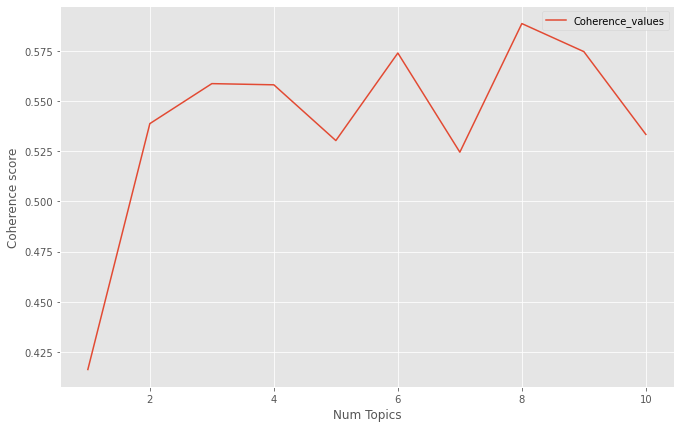

In [21]:
# model_list, coherence_values = compute_coherence_values(dictionary=bigram_id2word, corpus=bigram_corpus, texts=data_bigrams, start=start, limit=limit, step=step)

# Show graph

x = model_values_df['num_topics'].values.tolist()

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)

plt.title('LDA Mallet')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence_values"], loc='best')
plt.show()

The coherence score peaks at creating 6 topics before it plummets. 

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4163
Num Topics = 2  has Coherence Value of 0.5387
Num Topics = 3  has Coherence Value of 0.5586
Num Topics = 4  has Coherence Value of 0.558
Num Topics = 5  has Coherence Value of 0.5302
Num Topics = 6  has Coherence Value of 0.5738
Num Topics = 7  has Coherence Value of 0.5245
Num Topics = 8  has Coherence Value of 0.5885
Num Topics = 9  has Coherence Value of 0.5745
Num Topics = 10  has Coherence Value of 0.5333


Viewing the topics and checking if they make sense helps to decide how many topics is the optimal value. I'll be intrepreting the 5 and 6 topics.

## Exporting the optimal model to pickle file

In [23]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/amd_optimal_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(optimal_model, out_file)
out_file.close()

## Exporting the 5 topics trained model to pickle file

In [24]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/amd_5_topics_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(model_values_df['model_list'][4], out_file)
out_file.close()

## Importing the optimal mallet model pickle file

In [25]:
# pkl_filename = "./models/amd_optimal_ldamallet_model.pkl"
# infile = open(pkl_filename,'rb')
# optimal_model = pickle.load(infile)
# infile.close()

In [26]:
# optimal_model

## Importing the 5 topics mallet model pickle file

In [27]:
pkl_filename = "./models/amd_5_topics_ldamallet_model.pkl"
infile = open(pkl_filename,'rb')
topic_5_ldamallet = pickle.load(infile)
infile.close()

In [28]:
# topic_5_ldamallet 

## Displaying topics for the optimal model (6 topics)

In [29]:
pprint(optimal_model.show_topics(formatted=False))

[(0,
  [('gpu', 0.05287504974134501),
   ('cpu', 0.036211699164345405),
   ('vram', 0.03198368483883804),
   ('lower', 0.017608436132113013),
   ('end', 0.0173099880620772),
   ('power', 0.01681257461201751),
   ('true', 0.011341026661360923),
   ('gaming', 0.011291285316354954),
   ('16gb', 0.010843613211301234),
   ('case', 0.010644647831277358)]),
 (1,
  [('rtx', 0.0397099779122251),
   ('year', 0.03644482857966004),
   ('4k', 0.027225583405358685),
   ('console', 0.023960434072793624),
   ('series', 0.017094017094017096),
   ('pc', 0.01699798329011812),
   ('1440p', 0.016613848074522233),
   ('good', 0.01627772976087583),
   ('fps', 0.01598962834917891),
   ('gaming', 0.014549121290694324)]),
 (2,
  [('dl', 0.06938946584082335),
   ('game', 0.0668746798304848),
   ('ray_tracing', 0.03418246169608345),
   ('rt', 0.02742979555721138),
   ('feature', 0.02696409444418572),
   ('support', 0.021468821310482934),
   ('raytracing', 0.016066688399385274),
   ('hardware', 0.01439016439249289

## Interpreting the 6 topics 

Topic 0
* Comparing against the price and the performance

Topic 1
* Driver related issue

Topic 2
* GPU features: ray_tracing, dlss and resolutions: 1440p, 4K

Topic 3
* Stock availability during launch of GPUs

Topic 4
* Price and performance for GPU models

Topic 5
* Comparison against the gaming consoles and the pc

## Displaying 5 topics

In [30]:
pprint(topic_5_ldamallet.show_topics(formatted=False))

[(0,
  [('price', 0.049831609692128874),
   ('3080', 0.04753673292999136),
   ('3070', 0.04396030161237445),
   ('6800', 0.04154621047298304),
   ('3090', 0.028313414597800495),
   ('6800xt', 0.028224003814860073),
   ('vram', 0.019163711143563914),
   ('6900xt', 0.016839030787112925),
   ('benchmark', 0.016272762495156915),
   ('xt', 0.013977885733019403)]),
 (1,
  [('card', 0.044638676447635396),
   ('people', 0.030466677071952553),
   ('buy', 0.023130950522865616),
   ('wait', 0.01919775245824879),
   ('stock', 0.018386140159200873),
   ('point', 0.012517558919931325),
   ('good', 0.011737162478539098),
   ('release', 0.011425003901982207),
   ('bad', 0.009708131730919308),
   ('guess', 0.00895895114718277)]),
 (2,
  [('dl', 0.04345416897547318),
   ('game', 0.04187931989850972),
   ('ray_tracing', 0.021406281897984776),
   ('rt', 0.017177520487619936),
   ('feature', 0.01688588176966374),
   ('4k', 0.016535915308116305),
   ('console', 0.014698591384992271),
   ('support', 0.013444

## Interpreting the 5 topics 

Topic 0
* Driver related issue

Topic 1
* Stock availability

Topic 2
* GPU features: ray_tracing, dlss and resolutions: 1440p, 4K

Topic 3
* Price and performance for GPU models

Topic 4
* Have to do with intel, amd and Nvidia cpu and gpus. Unable to intrepret well. 

As I find the 6 topics to be the most intrepretable as well as it's one of the highest coherence score among the other models, I'll be selecting to it to move forward with the project.

# Finding the dominant topic in each sentence

I would like to investigate the dominant topics for the documents and see if it makes sense.

In [31]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row in enumerate(ldamodel[corpus]): # ldamodel[corpus] --> Provides a list of the probability values of which topic a document belongs to
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # Sorts the probabilities of a document is descending order
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic (As it's sorted in descending order, the highest probability is the first topic which is index 0)
                wp = ldamodel.show_topic(topic_num) # Obtain the dominant topic for the document
                topic_keywords = ", ".join([word for word, prop in wp]) # Gets the topic keys words for the topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

Notes: The last model trained **must match** with the last optimal_file_doctopics text file. If not, there will be an error message.

In [32]:
# Retrain the model if you've have not done so
# optimal_num_topics = 6
# optimal_model = LdaMallet(mallet_path, corpus=bigram_corpus, num_topics=optimal_num_topics, id2word=bigram_id2word,
#                                                  prefix='optimal_', random_seed=42)

In [33]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bigram_corpus, texts=data_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,1.0,0.1368,"rtx, year, 4k, console, series, pc, 1440p, goo...","[sound, samsung_8nm, cheap]"
1,1,7.0,0.1507,"card, stock, launch, order, day, gonna, waitin...","[ethic, mongol, invasion, tech]"
2,2,2.0,0.1447,"dl, game, ray_tracing, rt, feature, support, r...","[nvidia, software, ai, learning, big, selling,..."
3,3,6.0,0.2130,"amd, nvidia, card, intel, good, market, compet...","[excited, amd, guy, compete, going, nvidia, br..."
4,4,3.0,0.1737,"price, 3070, 6800, xt, 500, 2080ti, faster, 50...","[think, nvidia, actualy, competing, new, conso..."
5,5,6.0,0.2445,"amd, nvidia, card, intel, good, market, compet...","[reputable, leak, rdna2, say, 40, 50, faster, ..."
6,6,6.0,0.3337,"amd, nvidia, card, intel, good, market, compet...","[im, sure, amd, good, rdna, generation, rt, im..."
7,7,6.0,0.1619,"amd, nvidia, card, intel, good, market, compet...","[b4, refresh, ampere, 7nm, throw, dirt, wound,..."
8,8,3.0,0.2211,"price, 3070, 6800, xt, 500, 2080ti, faster, 50...","[thread, deleted, aswell, post, r, p, amd, off..."
9,9,0.0,0.1439,"gpu, cpu, vram, lower, end, power, true, gamin...","[amd, going, need, pull, double, 5700xt, wish,..."


In [34]:
# Sort the dataframe in ascending order by the topic percentage contribution
df_dominant_topic_sorted = df_dominant_topic.sort_values('Topic_Perc_Contrib', ascending=False)
idx = np.random.randint(df_dominant_topic_sorted.shape[0])
# idx = 250
document = df_dominant_topic_sorted[['Document']].iloc[idx].values
dominant_topic = df_dominant_topic_sorted[['Dominant_Topic']].iloc[idx].values
dominant_keywords = df_dominant_topic_sorted[['Keywords']].iloc[idx].values

In [35]:
print(f'Dominant keywords: {dominant_keywords} \n\nDocument:{document}')

Dominant keywords: ['card, stock, launch, order, day, gonna, waiting, cc, aib, reference'] 

Document:[list(['bought', 'week', 'amazon', 'equivalent', 'serie', '5000', 'cpu', 'higher', 'priced', 'send', 'new', 'socket'])]


The document is relating to the price and performance of AMD against the Nividia's pascal and ampere's generation of GPUs as well as discussing about the Thermal Design Power (TDP) in which the GPUs generate heat and draw electricity as `100w` was seen in the document. 

In [36]:
print(f'Dominant keywords: {dominant_keywords} \n\n Document:{document}')

Dominant keywords: ['card, stock, launch, order, day, gonna, waiting, cc, aib, reference'] 

 Document:[list(['bought', 'week', 'amazon', 'equivalent', 'serie', '5000', 'cpu', 'higher', 'priced', 'send', 'new', 'socket'])]


In the above document, the dominant keywords reflect the document with purchasing a GPU. 

# Find the most representative document for each topic

In [37]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format the columns
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5488,"gpu, cpu, vram, lower, end, power, true, gamin...","[selection, frame, index, 0, excludes, type, x..."
1,1.0,0.4488,"rtx, year, 4k, console, series, pc, 1440p, goo...","[ssd, year, old, ocz, vertex, max, iop, 128gb,..."
2,2.0,0.5388,"dl, game, ray_tracing, rt, feature, support, r...","[example, ray_tracing, insanely, computational..."
3,3.0,0.3986,"price, 3070, 6800, xt, 500, 2080ti, faster, 50...","[looking, saving, perspective, way, generation..."
4,4.0,0.4112,"3080, 3090, 6800xt, wait, 6900xt, benchmark, m...","[wrong, look, official, benchmark, slide, smar..."
5,5.0,0.6850,"people, buy, driver, time, issue, good, bad, r...","[corrected, multiple, time, insinuating, decis..."
6,6.0,0.4498,"amd, nvidia, card, intel, good, market, compet...","[amd, nvidia, buy, silicon, company, mainly, s..."
7,7.0,0.5306,"card, stock, launch, order, day, gonna, waitin...","[alright, called, couple, cc, location, 4038, ..."


## Most representative document for Topic 0

In [38]:
# Create a helper function to display the most representative documents for a topic
def display_representative_document(topic_n, df):
    dominant_keywords = df['Keywords'].loc[topic_n]
    document_topic = " ".join(df['Representative Text'].loc[topic_n])
    
    print(f'*******Topic {topic_n}********\n\nDominant keywords: {dominant_keywords} \n\nDocument:{document_topic}')

In [39]:
display_representative_document(0, sent_topics_sorteddf_mallet)

*******Topic 0********

Dominant keywords: gpu, cpu, vram, lower, end, power, true, gaming, 16gb, case 

Document:selection frame index 0 excludes type xpath expr body main role main div_class layout content div_contains class region div_contains class block div_class container div_class row flex h4 includes type xpath expr body main role main div_class layout content div_contains class region div_contains class block div_class container div_class row flex div dynamic true delay 0 ignoreemptytext true includestyle false dataattr text make_sense thanks


The document talks about the price and performance of AMD's 6800xt and 6900xt which fits the topic of the `price` and `performance` of the card.

## Most representative document for Topic 1

In [40]:
display_representative_document(1, sent_topics_sorteddf_mallet)

*******Topic 1********

Dominant keywords: rtx, year, 4k, console, series, pc, 1440p, good, fps, gaming 

Document:ssd year old ocz vertex max iop 128gb guess size house lot game especially ton game large day ssd run o default program software suite game run oldfashioned 7200 rpm hdds far cpu go bought time 290 currently running 3770k oc 4 5ghz 12gb ddr3 1600mhz ram tech obsessed guy old standard stuff ancient obsolete fallen hard time financially past year sense surprised longevity part able squeeze wrong notice need upgrade day able smoothly run star citizen example 15 20fps best fs2020 give 20 30 frame best medium setting lot stuttering framedrops depending area horrendous loadtimes old hdds stuff ac odyssey shadow_tomb raider customized term setting medium ultra run 30 45 frame depending area stuff witcher ran 60fps ultra hairworks play 30 45 fps sense worried able run cyberpunk_2077 decent setting framerate 6 7 year single configuration able play relatively similar console experie

The document does not make sense as it's talking about HTML syntaxes which the model poorly interpreted.

## Most representative document for Topic 2

In [41]:
display_representative_document(2, sent_topics_sorteddf_mallet)

*******Topic 2********

Dominant keywords: dl, game, ray_tracing, rt, feature, support, raytracing, hardware, 0, lot 

Document:example ray_tracing insanely computationally expensive push higher higher resolution jumping 1080p 1440p 4k adding big load ray_tracing exacerbates essentially enabling ray_tracing half huge hit think agree exactly dl important negates halving ray_tracing guarantee devs away completely fake baking lighting cube map use rtx know long way away unfortunately yes computationally expensive far easier devs implement physic based work box hundred hour cube map hit generally getting ray_tracing effect certain area example ray_traced environmental lighting effect muzzle trade lighting option severe penalty yep absolute best implementation control far good cyberpunk implementation albeit bet extremely good given close partnership nvidia said implementation computational cost high best cast ray pixel enormously far realistic rendering theoretically say need cast 500 ray 

The document discusses about [ray tracing](https://www.techradar.com/news/ray-tracing) which gives more lifelike shadows and reflections, along with much-improved translucence and scattering in games. This fits the topic in which it has the keyword `ray_tracing`, `performance`.

## Most representative document for Topic 3

In [42]:
display_representative_document(3, sent_topics_sorteddf_mallet)

*******Topic 3********

Dominant keywords: price, 3070, 6800, xt, 500, 2080ti, faster, 50, pricing, rx 

Document:looking saving perspective way generational price bearing mind 2080_ti whopping 70 expensive 1080 ti 1080 ti 50 expensive 980 ti 2080_ti best 35 better 1080 ti 1080 ti avg 50 faster 980 ti 2080_ti impressive begin 2080_ti 500 3070 mean considering 3070 memory gddr6x 500 3070 mean 3060 likely 400 wanna guess


The document talks about the pre ordering AMD's 6800xt which fits the topic on purchasing a GPU during the GPU's launch

## Most representative document for Topic 4

In [43]:
display_representative_document(4, sent_topics_sorteddf_mallet)

*******Topic 4********

Dominant keywords: 3080, 3090, 6800xt, wait, 6900xt, benchmark, memory, 10, cheaper, review 

Document:wrong look official benchmark slide smart_access memory google smart_access memory technology available 5000_series ryzen 6000_series radeon 6900xt smart_access memory rage_mode lmao edit looked wrong 6800 6900_xt slide smart_access memory 6800 xt slide edit2 different 6800xt slide smart_access memory 6800xt virtually identical 3080 5000_series ryzen processor ahead slightly game slightly edit3 realized rage_mode probably increase tdp outside specified know sure actual review 6900xt 350w rage_mode


The document compares Nvidia's GPUs, the 3070, 3080 and the 3090 against AMD's GPUs, the 6800, 6800xt and the 6900xt which adequately matches the topic.

## Most representative document for Topic 5

In [44]:
display_representative_document(5, sent_topics_sorteddf_mallet)

*******Topic 5********

Dominant keywords: people, buy, driver, time, issue, good, bad, reason, sell, product 

Document:corrected multiple time insinuating decision stem 700 msrp mentioned comment bud wrong disclosed reply comment original reply stated sounded bad idea original comment disclosed information original reply said sounded bad idea possible different conclusion different circumstance clarified simply said 6800xt obviously 6900xt expensive imply terrible_idea simply implied look worth trouble insinuate decision stem 700 msrp insinuated terrible_idea upset look r hardwareswap selling 3080s loss arguing entirely bad faith point cared paid 150 base 700 msrp place decision entirely stem 850 price point time repeat stop twisting single word fuck word twist care r hardwareswap rate 3080 aways talking price launch date new radeon card later imagined talking usual case_scenario reason sound calm f buddy completely blind think sell right 850 model stated comment learn read stop back

Unable to intrepret the document well as it discusses about the turing complete machine, whereas the topic discusses about the PC and gaming consoles.

# Topic distribution across documents

In [45]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num = pd.Series(sorted(df_topic_sents_keywords['Dominant_Topic'].unique()))
topic_keywords = sent_topics_sorteddf_mallet['Keywords']

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num, topic_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(6)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"gpu, cpu, vram, lower, end, power, true, gamin...",1836,0.1264
1.0,1.0,"rtx, year, 4k, console, series, pc, 1440p, goo...",1538,0.1059
2.0,2.0,"dl, game, ray_tracing, rt, feature, support, r...",2016,0.1388
3.0,3.0,"price, 3070, 6800, xt, 500, 2080ti, faster, 50...",2105,0.1449
4.0,4.0,"3080, 3090, 6800xt, wait, 6900xt, benchmark, m...",1768,0.1217
5.0,5.0,"people, buy, driver, time, issue, good, bad, r...",1581,0.1088


In [46]:
# Sort the Percentage of documents in descending order
df_dominant_topics.sort_values(by='Perc_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
7.0,7.0,"card, stock, launch, order, day, gonna, waitin...",2150,0.1480
3.0,3.0,"price, 3070, 6800, xt, 500, 2080ti, faster, 50...",2105,0.1449
2.0,2.0,"dl, game, ray_tracing, rt, feature, support, r...",2016,0.1388
0.0,0.0,"gpu, cpu, vram, lower, end, power, true, gamin...",1836,0.1264
4.0,4.0,"3080, 3090, 6800xt, wait, 6900xt, benchmark, m...",1768,0.1217
5.0,5.0,"people, buy, driver, time, issue, good, bad, r...",1581,0.1088
1.0,1.0,"rtx, year, 4k, console, series, pc, 1440p, goo...",1538,0.1059
6.0,6.0,"amd, nvidia, card, intel, good, market, compet...",1532,0.1055


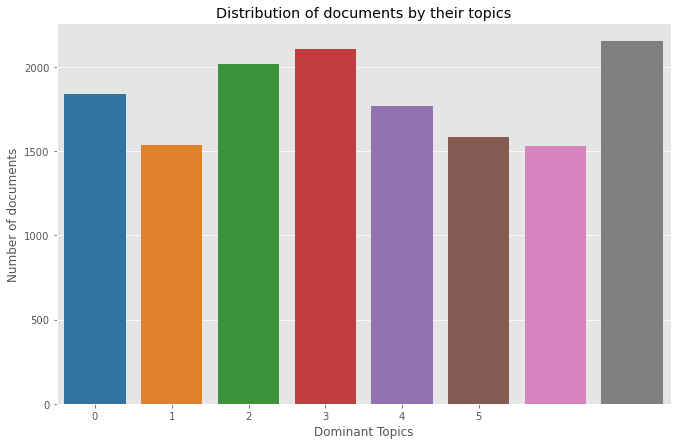

In [47]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

plt.figure(figsize=(11,7))
sns.barplot(x='Dominant_Topic', y='Num_Documents',data=df_dominant_topics, palette=cols)

plt.title('Distribution of documents by their topics')
plt.xticks(np.arange(6),[x for x in range(6)])
plt.xlabel('Dominant Topics')
plt.ylabel('Number of documents');

Topic 3 has the been assigned the most often to the documents with close to 3000 documents being assigned while making up 20% of the topics assigned.
Stock availability during the launch of the GPUs is the most discussed for the AMD's subreddit with Topic 4 coming in second, which goes into comparing the price and performance of the AMD and Nvidia's GPUs. 

The least discussed is Topic 5 which discusses about the [RDNA 2 GPUs](https://www.pcworld.com/article/3528861/what-the-new-xbox-series-x-specs-tell-us-about-amds-next-gen-radeon-graphics-cards.html) powering the new gaming consoles, Xbox X series and the PS5. It seems that most of the subreddit users are PC gamers given the least number of Topic 5 documents.

# Frequency Distribution of Word Counts in Documents by dominant topic

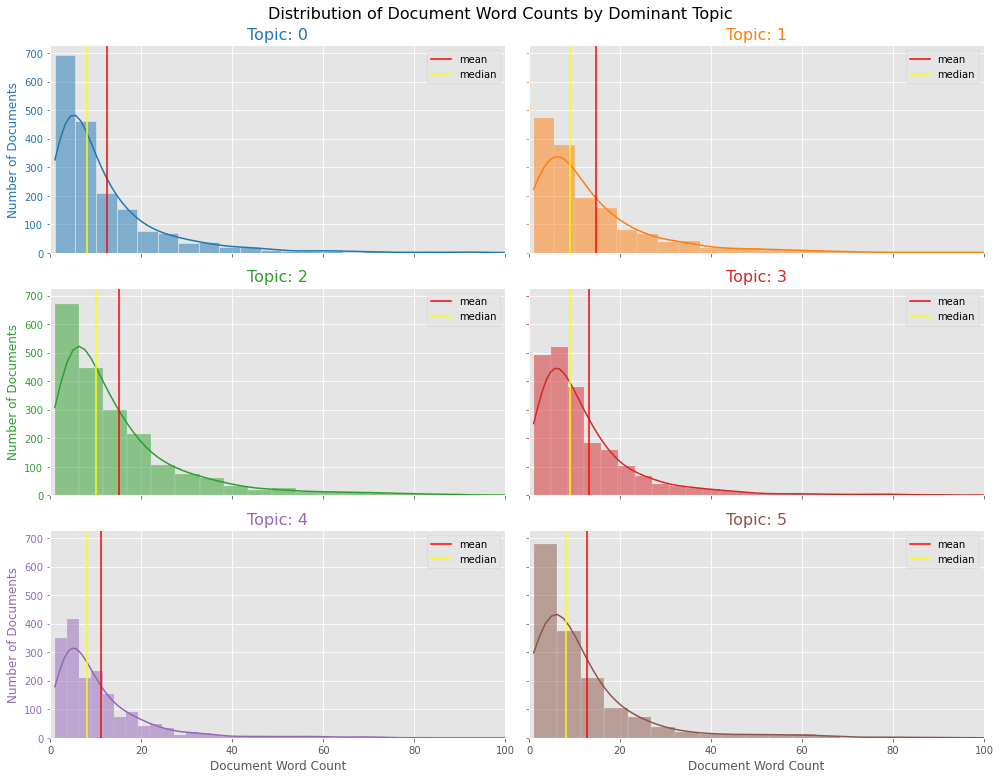

In [48]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(3,2, figsize=(14,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i]
    doc_lens = df_dominant_topic_sub.Document.map(lambda token: len(token)).tolist()
    #ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.histplot(doc_lens, bins=50, color=cols[i], kde=True, ax=ax) # ax.twinx()
    # Mean
    ax.axvline(np.mean(doc_lens), color='red', label='mean')
    # Median
    ax.axvline(np.median(doc_lens), color='yellow', label='median')
    ax.legend()
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,375,9))
plt.xlim(0,100)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.tight_layout()
plt.show()

All of the distributions shows a right tailed skewed graph in which the mean and median are quite close.

# Word Clouds of Top N Keywords in Each Topic

In [49]:
stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like', '1', '2', '3', '5', 'got'])

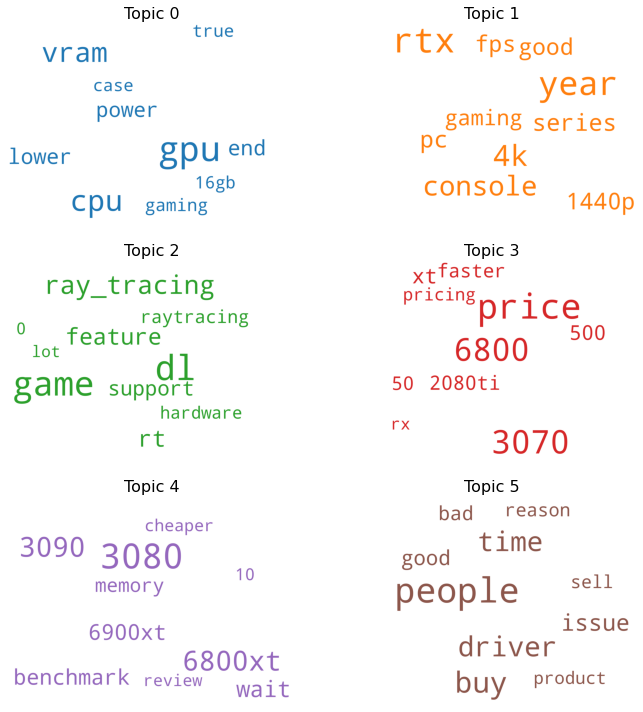

In [50]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

In [51]:
data_flat = [word for word_lst in data_bigrams for word in word_lst] # Creates a list of words 
counter = Counter(data_flat) # Counts the frequency of the tokens and stores in a dictionary
counter

Counter({'sound': 124,
         'samsung_8nm': 25,
         'cheap': 94,
         'ethic': 3,
         'mongol': 14,
         'invasion': 3,
         'tech': 191,
         'nvidia': 2584,
         'software': 231,
         'ai': 102,
         'learning': 8,
         'big': 323,
         'selling': 110,
         'point': 502,
         'excited': 57,
         'amd': 3648,
         'guy': 175,
         'compete': 256,
         'going': 894,
         'brand_loyalty': 17,
         'sucker': 12,
         'think': 1149,
         'actualy': 1,
         'competing': 69,
         'new': 747,
         'console': 505,
         'price': 1672,
         '499': 90,
         '2080ti': 410,
         'dumping': 1,
         'reputable': 5,
         'leak': 63,
         'rdna2': 190,
         'say': 95,
         '40': 49,
         '50': 373,
         'faster': 382,
         'couple': 99,
         'rumored': 23,
         'focus': 29,
         'power': 338,
         'efficiency': 63,
         'advantage': 11

In [52]:
out = [[word, i , weight, counter[word]] for i, topic in topics for word, weight in topic]
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.head()

,word,topic_id,importance,word_count
0,gpu,0,0.052875,1063
1,cpu,0,0.036212,728
2,vram,0,0.031984,643
3,lower,0,0.017608,355
4,end,0,0.017310,348


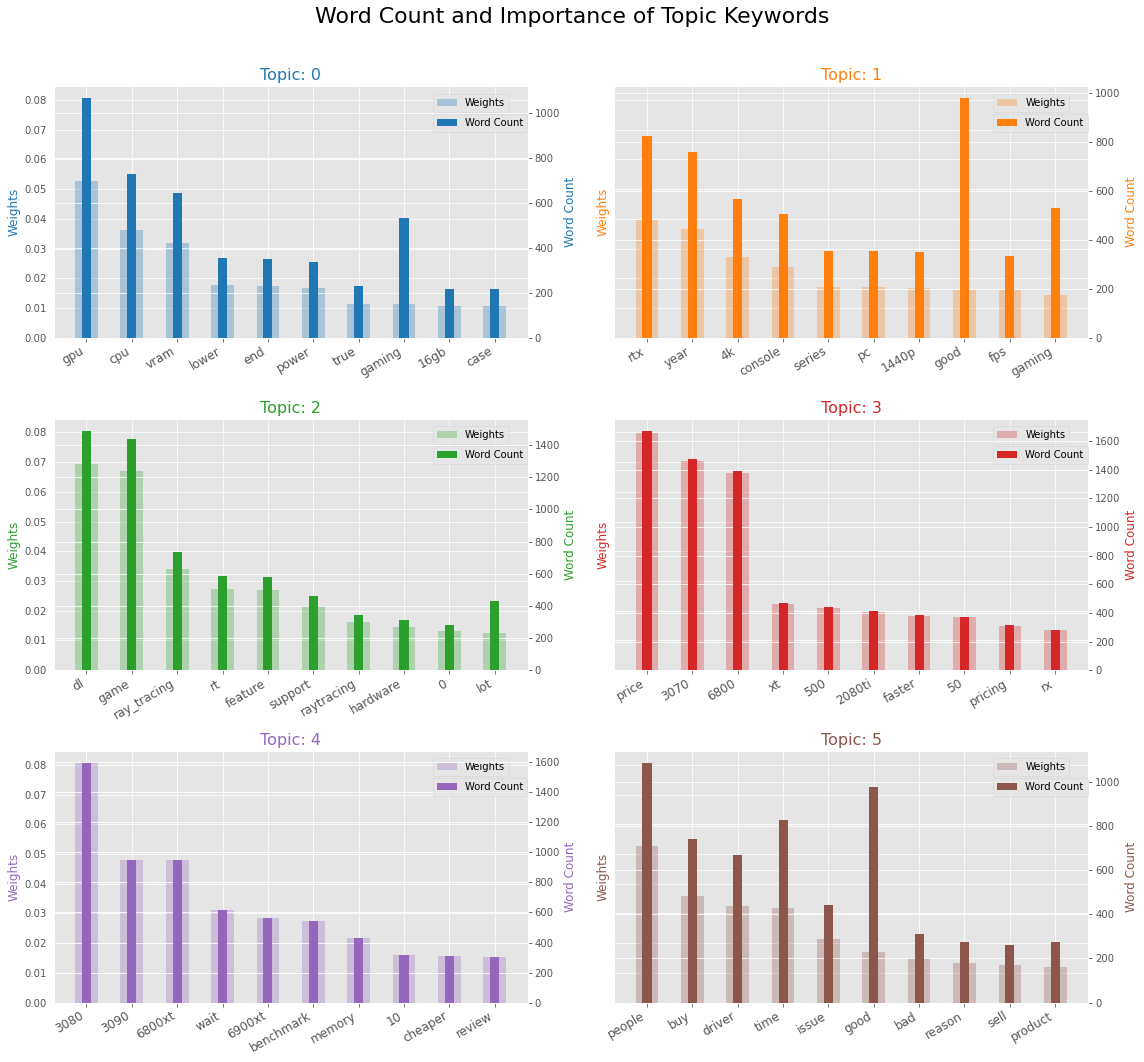

In [53]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,14), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Weights')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Word Count')
    ax.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylabel('Word Count', color=cols[i])
    # Sets the ylimits for the axes
    #ax_twin.set_ylim(0, 0.030)
    #ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'].tolist(), rotation=30, horizontalalignment= 'right', fontsize=12)
    ax_twin.legend(loc=[0.80,0.82])
    ax.legend(loc=[0.80,0.90])
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Intrepreting the topic word frequency and their weights

Topic 0:
* Equally distributed weights
* The frequency of the words have little correlation with the weights

Topic 1:
* Equally distributed weights
* amd has the highest word frequency
* gpu is more favoured to gpus

Topic 2:
* Performance has the highest frequency, but the weights are not that high
* Gaming features: dlss has a higher weight and frequency compared to ray_tracing, which possibly means a more favoured feature among gamers.
* Resolution: Surprisingly, 4k resolution has a higher frequency and weight compared to 1440p resolution, which is not so main stream yet. 1440p resolution is reaching mainstream crowd.

Topic 3:
* Relating to GPU purchase during the launch
* card seems to appear often, possibly could include in the stopwords
* lol, yeah seems to make little sense here, could add to stopwords

Topic 4:
* The GPU models have a relatively higher word count compared to their frequency
* Nvidia's RTX 3070 and 3080 seems to be favoured over the other GPU models

Topic 5:
* Compared to the other topics, the weights are equal to or higher than their word count.
* good and great share a similar meaning, could potentially add one of the to stopwords.

# Most discussed topics in the documents (Possibly remove)

Note: It'll take **more than an hour** to run if all the documents are added.

In [54]:
# Sentence Coloring of N Sentences
# def topics_per_document(model, corpus, start=0, end=1):
#     corpus_sel = corpus[start:end] # Obtain a slice of nth documents
#     dominant_topics = []
#     topic_percentages = []
#     for i, corp in enumerate(corpus_sel): # For each document
#         doc = model[corp] # Gets the nth document
#         dominant_topic, topic_percs = sorted(doc, key = lambda x: x[1], reverse=True)[0] # Gets the dominant topic and topic percentage by sorting the topic percentage prob in descending order
#         dominant_topics.append((i, dominant_topic))
#         topic_percentages.append(topic_percs)
#     return(dominant_topics, topic_percentages)

# dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=bigram_corpus, end=10)  

In [55]:
# Distribution of Dominant Topics in Each Document
# df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
# dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
# df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
# topic_weightage_by_doc = pd.DataFrame([{t} for t in topic_percentages])
# df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
# topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
#                                  for j, (topic, wt) in enumerate(topics) if j < 3]

# df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
# df_top3words = df_top3words_stacked.groupby('topic_id').agg(', '.join)
# df_top3words.reset_index(level=0,inplace=True)

In [56]:
# df_top3words

In [57]:
# from matplotlib.ticker import FuncFormatter

# # Plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# # Topic Distribution by Dominant Topics
# ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
# ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
# tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
# ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
# ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# # Topic Distribution by Topic Weights
# ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
# ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
# ax2.xaxis.set_major_formatter(tick_formatter)
# ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

# plt.show()

# t-SNE Clustering Chart

In [59]:
# Get topic weights
topic_weights = []

for row_lst in optimal_model[bigram_corpus]:
    lst = []
    for topic_id, topic_perc in row_lst:
        lst.append(topic_perc)
    topic_weights.append(lst)
    

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=30, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
lgd_label = np.array(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])

source = ColumnDataSource(dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    color=mycolors[topic_num],
))

plot.scatter(x='x', y='y', color='color', source=source)
show(plot)

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.000s...
[t-SNE] Computed neighbors for 74 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.255122
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.897312
[t-SNE] KL divergence after 1000 iterations: 0.229635


Loading BokehJS ...

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised non-linear learning technique used for data exploration and visualizing higher dimensional data. It gives a sense of how the data is arranged in a high dimensional-space. As t-SNE preserves small pairwise compared to Principal Component Analysis (PCA), we can see that the Topic 0, 2, 4 and 5 are close together which shows their relationship

# pyLDAVis

In [60]:
# Visualize the topics for the bigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'amd_' + 'bigram_' +'mallet_ldavis_prepared_'+str(num_topics))

optimal_model_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
bigram_mallet_vis = pyLDAvis.gensim.prepare(optimal_model_lda, bigram_corpus, bigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(bigram_mallet_vis, os.getcwd()+ '\\visualization\\' + 'amd_' + 'bigram_' + 'mallet_ldavis_prepared_'+ str(num_topics) +'.html')
bigram_mallet_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.044384  0.249173       1        1  12.892264
1      0.042938  0.148201       2        1  12.811487
6     -0.268284  0.093317       3        1  12.726141
5      0.044024  0.058309       4        1  12.621682
0      0.193936  0.078317       5        1  12.533812
3      0.187309 -0.256385       6        1  12.497241
4      0.067600 -0.205045       7        1  12.110186
7     -0.311908 -0.165887       8        1  11.807186, topic_info=         Term         Freq        Total Category  logprob  loglift
14        amd  4150.000000  4150.000000  Default  30.0000  30.0000
10     nvidia  2939.000000  2939.000000  Default  29.0000  29.0000
28      price  1887.000000  1887.000000  Default  28.0000  28.0000
99       3080  1846.000000  1846.000000  Default  27.0000  27.0000
385        dl  1693.000000  1693.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
198     month   231.435962   346.373178   Topic8  -4.5703   1.7332
998     start   126.443062   135.706483   Topic8  -5.1748   2.0658
2407  version   127.572018   138.022318   Topic8  -5.1659   2.0577
246   release   181.761902   415.119299   Topic8  -4.8119   1.3106
91       edit   137.732621   207.230794   Topic8  -5.0893   1.7279

[592 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
416       1  1.001159      0
7475      2  0.858769     07
818       7  1.001130     10
132       6  0.996562    100
132       7  0.004259    100
...     ...       ...    ...
8266      6  0.885943   yaas
194       2  1.000200   year
3984      7  1.036334  youre
378       3  0.015800    zen
378       5  0.979598    zen

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 7, 6, 1, 4, 5, 8])

The bubbles are spread further apart compared to the LDA's pyLDAvis with the exception of topic 3 and 4. This shows that the topics are distinguishable from one another. Also, it seems that the bubbles are of similar sizes which means that the documents are evenly distributed across the topics.